In [15]:
import pandas as pd
import re
import unicodedata
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from nltk.probability import FreqDist # This is for counting the most frequent words
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize # this is for counting the senteces
plt.style.use('ggplot')

# EDA of "GPT vs. Human: A Corpus of Research Abstracts"

In [16]:
data = pd.read_csv("data_set.csv" , index_col= False )
data.head(5)

,title,abstract,ai_generated,is_ai_generated
0,Are Advanced Potentials Anomalous?,Advanced electromagnetic potentials are indi...,False,0
1,Are Advanced Potentials Anomalous?,This research paper investigates the question ...,True,1
2,An efficient centralized binary multicast netw...,We give an algorithm for finding network enc...,False,0
3,An efficient centralized binary multicast netw...,The paper presents an efficient centralized bi...,True,1
4,Percolation transition in networks with degree...,We introduce an exponential random graph mod...,False,0


In [17]:
print(data.shape)
data.info()
# This dataset is bigger than the other one

(4053, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4053 entries, 0 to 4052
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            4053 non-null   object
 1   abstract         4053 non-null   object
 2   ai_generated     4053 non-null   bool  
 3   is_ai_generated  4053 non-null   int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 99.1+ KB


In [18]:
# Checking missing values...
data.isna().sum()
# No Missing values as before

title              0
abstract           0
ai_generated       0
is_ai_generated    0
dtype: int64

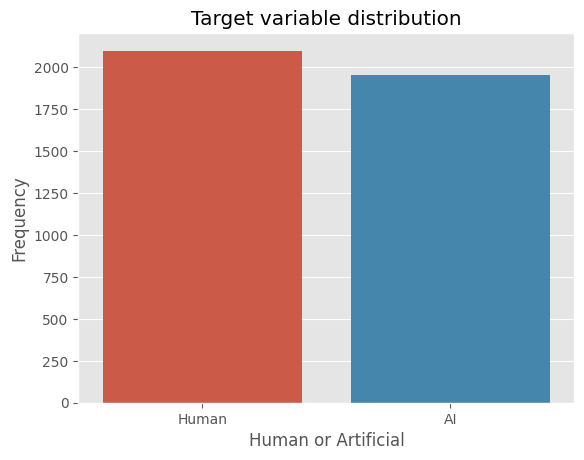

In [19]:
# What about the target class distro? It should be totally balanced because for every question we have 2 answers
fig = sns.countplot(data, x = 'ai_generated')
fig.set(title = 'Target variable distribution', xlabel = 'Human or Artificial', ylabel = 'Frequency', xticklabels=['Human','AI'] )
plt.show()
# There are a bit less AI responses

## EDA --> Counts and lengths

### Character Count

In [20]:
def article_length(text):
    return len(text)
data['length'] = data['abstract'].apply(article_length) 
print(data[data['is_ai_generated']==0].length.mean())
print(data[data['is_ai_generated']==1].length.mean())

911.6428571428571
790.5340501792115


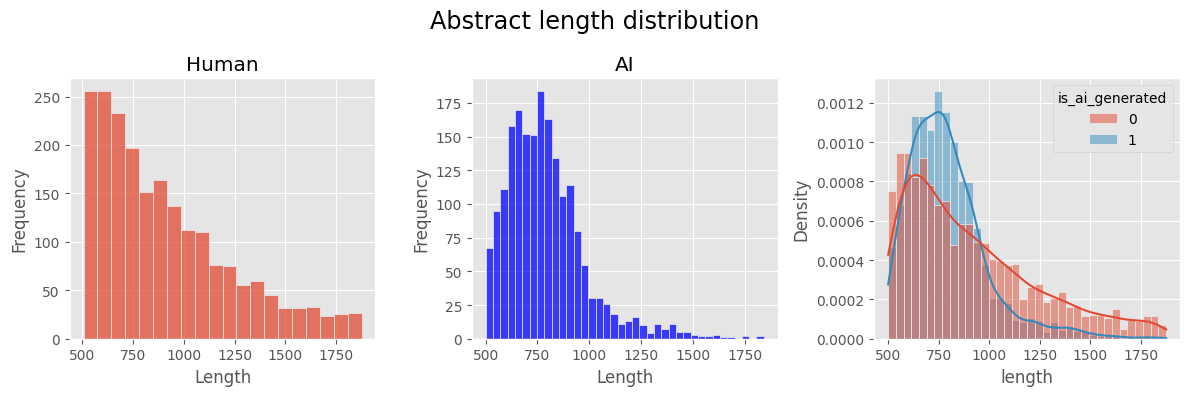

In [21]:
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'length', ax = axes[0])
fig_dist_human.set(title = 'Human', xlabel='Length', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'length', ax = axes[1], color = 'blue')
fig_dist_ai.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig.suptitle('Abstract length distribution', fontsize =  'xx-large')
sns.histplot(data = data, x = 'length', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2] ) # Overlapped
plt.tight_layout()

### Words Count

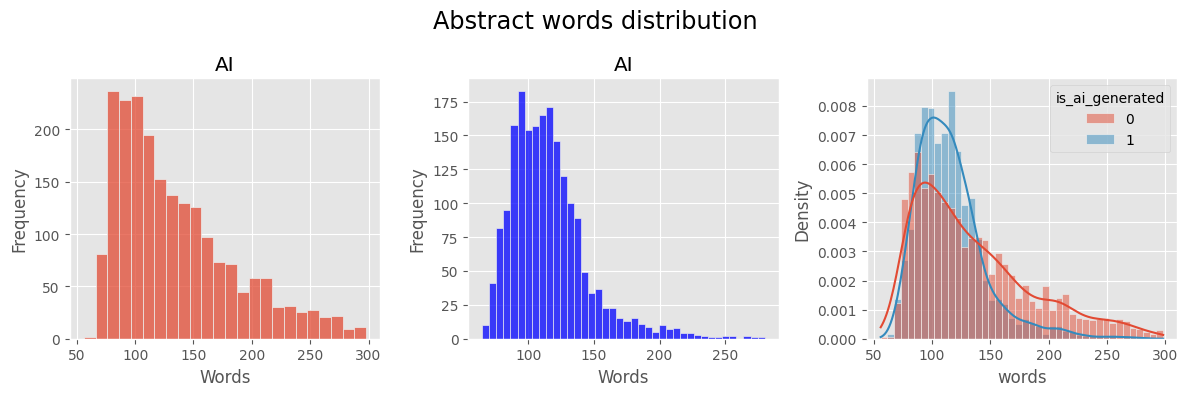

In [9]:
data['words'] = data['abstract'].apply(lambda x: len(str(x).split()))
figg, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'words', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'words', ax = axes[1], color='blue')
fig_dist_ai.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
sns.histplot(data = data, x = 'words', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2]) 
figg.suptitle('Abstract words distribution', fontsize =  'xx-large')
plt.tight_layout()

### Sentences Count

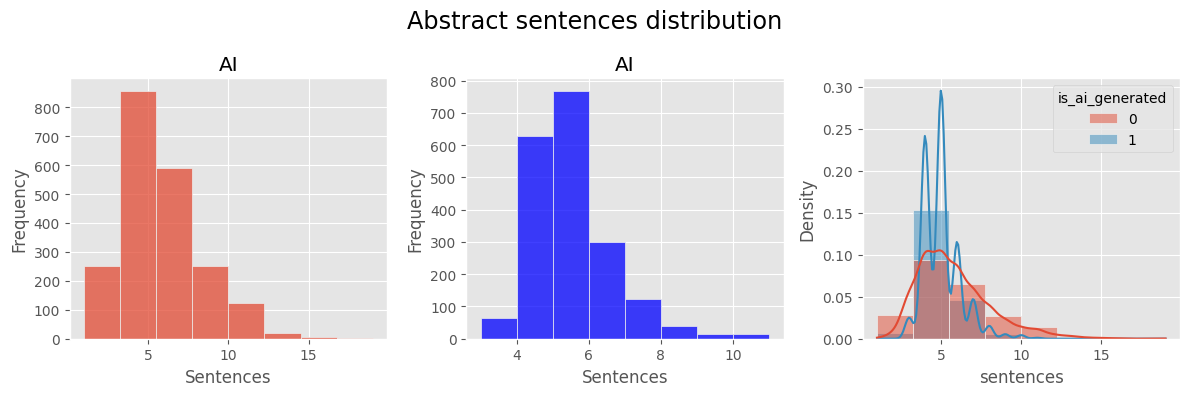

In [22]:
data['sentences'] = data['abstract'].map(lambda x: len(sent_tokenize(x)))
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_sentences_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'sentences', ax = axes[0], bins = 8)
fig_sentences_human.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
fig_sentences_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'sentences', ax = axes[1], color='blue',bins = 8)
fig_sentences_ai.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
sns.histplot(data = data, x = 'sentences', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2], bins = 8) 
fig.suptitle('Abstract sentences distribution', fontsize =  'xx-large')
plt.tight_layout()

# EDA --> Term frequency analysis

Steps we will follow:
1) Convert to lowercase
2) remove urls and html tags if any
3) Remove strange acceted characters if any
4) Remove punctuation
5) Remove extra white spaces 
6) Delet stop words

In [28]:
# Our functions
def lowering(text):
    return text.lower()

def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

In [24]:
len(data[data.abstract.str.contains('http')]) #only 4

4

In [25]:
data['abstract_clean'] = data.abstract.apply(lowering)   
data['abstract_clean'] = data.abstract_clean.apply(remove_url)
data['abstract_clean'] = data.abstract_clean.apply(remove_accents)
data['abstract_clean'] = data.abstract_clean.apply(remove_punctuation)
data['abstract_clean'] = data.abstract_clean.apply(remove_extra_spaces)
data['abstract_clean'] = data.abstract_clean.apply(delete_stopwords)

#### Most common words

In [29]:
def most_common_words(data):
    corpus = [word for i in data['abstract_clean'].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common(40)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return dict(zip(words, frequency))
most_1_human = most_common_words(data[data['is_ai_generated']==0])
most_1_ai = most_common_words(data[data['is_ai_generated']==1])

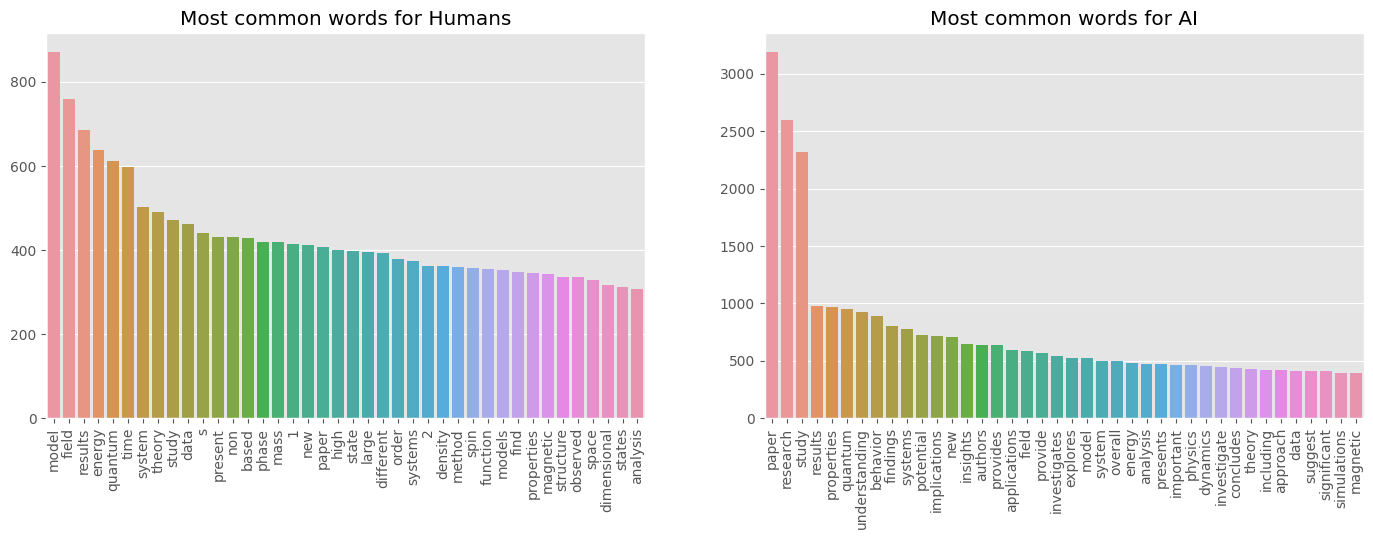

In [30]:
fig, axes = plt.subplots(1,2, figsize = (17,5))
sns.barplot(x = list(most_1_human.keys()), y = list(most_1_human.values()), ax = axes[0]).set(title="Most common words for Humans")
sns.barplot(x = list(most_1_ai.keys()), y = list(most_1_ai.values()), ax = axes[1]).set(title="Most common words for AI")
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.show()

#### Bigrams

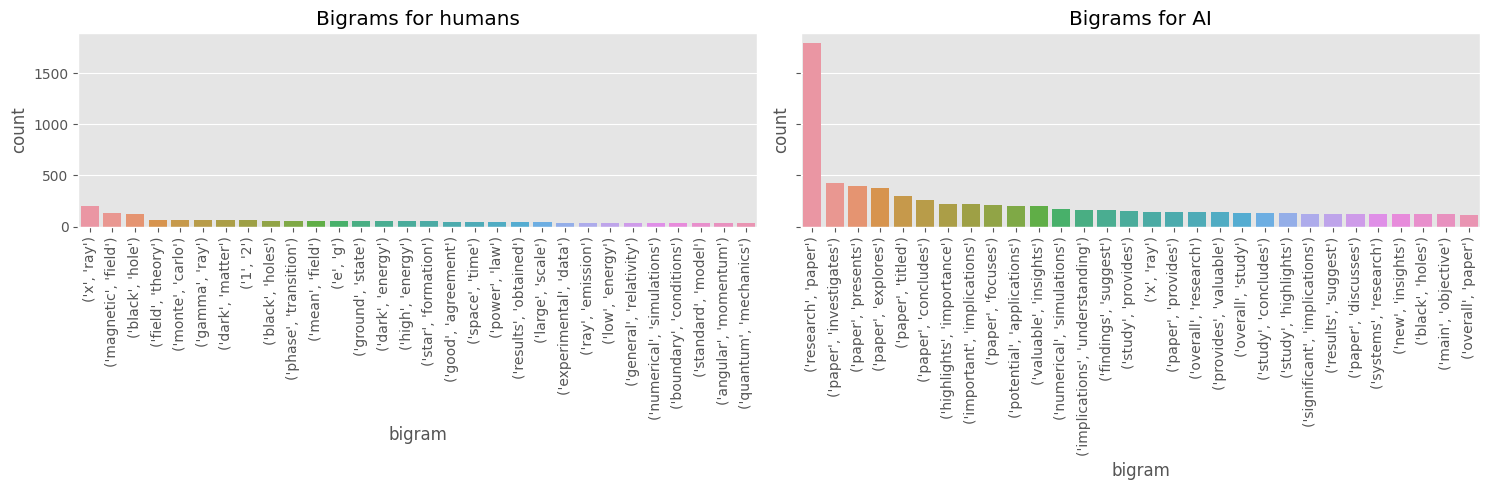

In [31]:
humans = data[data['is_ai_generated']==0]
corpus_humans = [word for i in humans.abstract_clean.str.split().values.tolist() for word in i]
bigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 2)).value_counts())
bigrams_df_h = bigrams_humans.reset_index()
bigrams_df_h.columns = ['bigram', 'count']

AI = data[data['is_ai_generated']==1]
corpus_AI = [word for i in AI.abstract_clean.str.split().values.tolist() for word in i]
bigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 2)).value_counts())
bigrams_df_AI = bigrams_AI.reset_index()
bigrams_df_AI.columns = ['bigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,5), sharey=True)
sns.barplot(bigrams_df_h.head(30), x = 'bigram', y ='count', ax=axes[0]).set(title = 'Bigrams for humans')
sns.barplot(bigrams_df_AI.head(30), x = 'bigram', y ='count', ax=axes[1]).set(title = 'Bigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

#### Trigrams

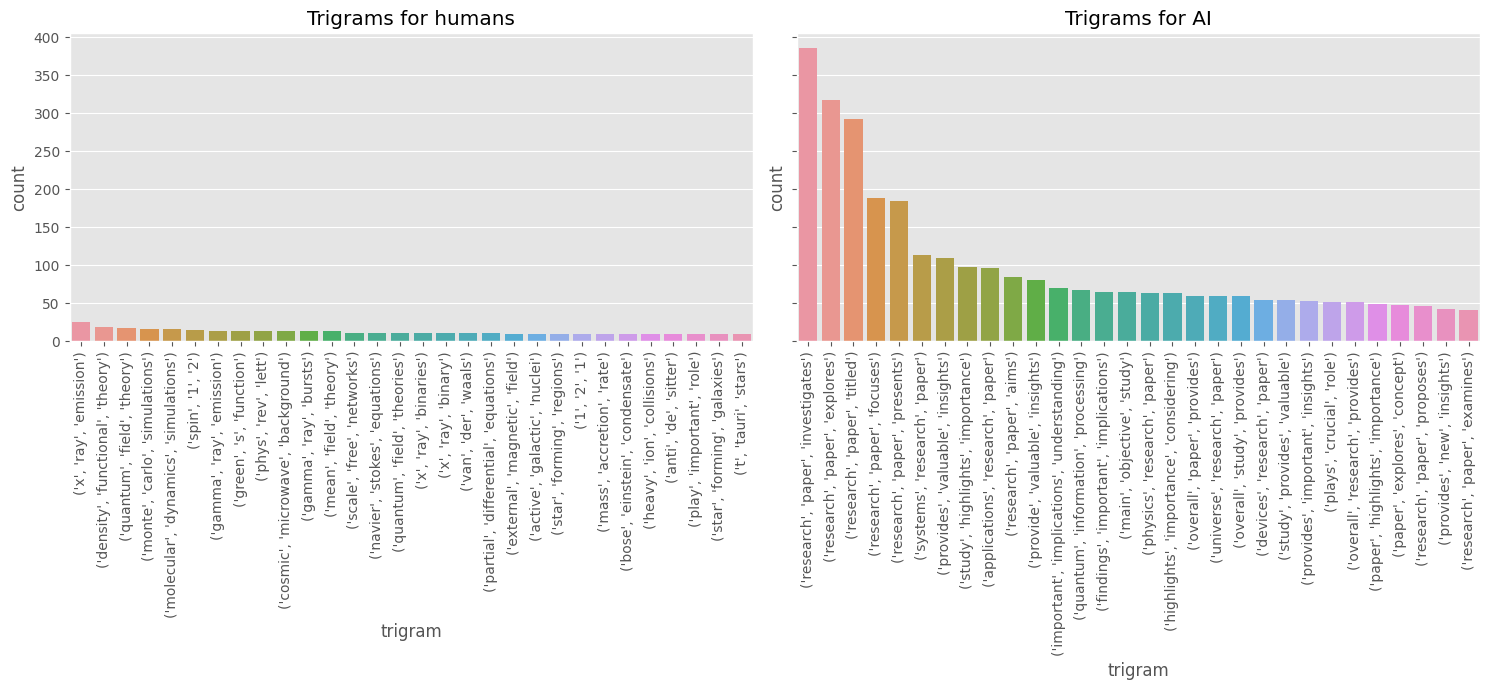

In [32]:
trigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 3)).value_counts())
trigrams_df_h = trigrams_humans.reset_index()
trigrams_df_h.columns = ['trigram', 'count']

trigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 3)).value_counts())
trigrams_df_AI = trigrams_AI.reset_index()
trigrams_df_AI.columns = ['trigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,7), sharey= True) 
sns.barplot(trigrams_df_h.head(30), x = 'trigram', y ='count', ax=axes[0]).set(title = 'Trigrams for humans')
sns.barplot(trigrams_df_AI.head(30), x = 'trigram', y ='count', ax=axes[1]).set(title = 'Trigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

# New column

In [33]:
corpus = [word for i in data.abstract_clean.str.split().values.tolist() for word in i]
bigram = (pd.Series(nltk.ngrams(corpus, 2)).value_counts())
unique_bigrams = bigram.head(50).index.tolist()
data['total_bigram_count'] = 0

In [34]:
def sum_bigram_counts(row):
    words = row['abstract_clean'].split()
    row_bigrams = list(nltk.ngrams(words, 2))
    
    # if the bigram is one of the 50 most frequent and if it is in the row sum 1
    row_count = sum(1 for bigram in row_bigrams if bigram in unique_bigrams)
    
    row['total_bigram_count'] = row_count

    return row

In [35]:
data = data.apply(sum_bigram_counts, axis=1)
data

,title,abstract,ai_generated,is_ai_generated,length,sentences,abstract_clean,total_bigram_count
0,Are Advanced Potentials Anomalous?,Advanced electromagnetic potentials are indi...,False,0,1157,7,advanced electromagnetic potentials indigenous...,0
1,Are Advanced Potentials Anomalous?,This research paper investigates the question ...,True,1,642,5,research paper investigates question advanced ...,5
2,An efficient centralized binary multicast netw...,We give an algorithm for finding network enc...,False,0,507,4,algorithm finding network encoding decoding eq...,0
3,An efficient centralized binary multicast netw...,The paper presents an efficient centralized bi...,True,1,940,6,paper presents efficient centralized binary mu...,2
4,Percolation transition in networks with degree...,We introduce an exponential random graph mod...,False,0,966,6,introduce exponential random graph model netwo...,1
...,...,...,...,...,...,...,...,...
4048,Vortex Dynamics at the Initial Stage of Resist...,This research paper investigates the vortex dy...,True,1,597,4,research paper investigates vortex dynamics su...,3
4049,The Veldkamp Space of Two-Qubits,Given a remarkable representation of the gen...,False,0,590,2,given remarkable representation generalized pa...,0
4050,The Veldkamp Space of Two-Qubits,The Veldkamp space of two-qubits is a mathemat...,True,1,901,6,veldkamp space qubits mathematical object desc...,4
4051,Fusion process studied with preequilibrium gia...,The equilibration of macroscopic degrees of ...,False,0,1069,8,equilibration macroscopic degrees freedom fusi...,1


# GLOVE?

In [108]:
import gensim.downloader
glove = gensim.downloader.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [109]:
dataset = [] 

In [112]:
for doc in data['abstract_clean']:
  vectors = [glove[word] for word in doc[0:10] if word in glove]
  